# DETOXIFICATION

In [83]:
%pip install -q torch
%pip install -q transformers[torch]
%pip install -q googletrans==3.1.0a0
%pip install -q fastparquet
%pip install sentencepiece

In [84]:
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from googletrans import Translator
from transformers import Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Lectura de datos

Vamos a leer el dataset de entrenamiento. Este dataset esta formado por 400 frases tóxicas por idioma en 9 idiomas diferentes y sus versiones no tóxicas. Formaremos un dataset conjunto que contenga para cada frase, su idioma de origen, la frase tóxica y la frase de-toxificada.

In [85]:
splits = {'en': 'data/en-00000-of-00001.parquet', 'ru': 'data/ru-00000-of-00001.parquet', 'uk': 'data/uk-00000-of-00001.parquet', 'de': 'data/de-00000-of-00001.parquet', 'es': 'data/es-00000-of-00001.parquet', 'am': 'data/am-00000-of-00001.parquet', 'zh': 'data/zh-00000-of-00001.parquet', 'ar': 'data/ar-00000-of-00001.parquet', 'hi': 'data/hi-00000-of-00001.parquet'}
df_en = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["en"])
df_uk = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["uk"])
df_ru = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ru"])
df_de = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["de"])
df_es = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["es"])
df_am = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["am"])
df_zh = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["zh"])
df_ar = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["ar"])
df_hi = pd.read_parquet("hf://datasets/textdetox/multilingual_paradetox/" + splits["hi"])

df_total = pd.concat([df_en, df_uk, df_ru, df_de, df_es, df_am, df_zh, df_ar, df_hi], keys=['en','uk', 'ru', 'de', 'es', 'am', 'zh-cn', 'ar', 'hi']).reset_index(level=[0])
df_total.rename(columns={"level_0":"source_language","toxic_sentence":"toxic_sentence", "neutral_sentence":"neutral_sentence"}, inplace=True)
df_total.sample(3)

,source_language,toxic_sentence,neutral_sentence
320,uk,Ти пизда як зміниласьДо того ти була ще терпим...,Ти сильно як зміниласьДо того ти була ще терпи...
150,en,"yea , who the fuck is government to be involve...","yes, who is the government to be involved in m..."
185,es,Es asombroso el nivel de estupidez-robotizació...,Resultado: Es sorprendente el nivel de robotiz...


## Traducción

Ahora vamos a traducir todo el dataset del idioma al original al ingles, para esto usaremos la librería de google translate.

In [86]:
translator = Translator()

def translate(text, source_lang, dest_lang):
    if source_lang == dest_lang:
        return text

    sol = translator.translate(text , src = source_lang, dest=dest_lang).text
    return sol

In [87]:
df_numpy = df_total.to_numpy()

In [90]:
toxic_translations = []
neutral_translations = []

for sentence in tqdm(df_numpy):
  toxic_translations.append(translate(sentence[1], sentence[0], 'en'))
  neutral_translations.append(translate(sentence[2], sentence[0], 'en'))


df_total["toxic_sentence_en"] = toxic_translations
df_total["neutral_sentence_en"] = neutral_translations

100%|██████████| 3600/3600 [05:47<00:00, 10.35it/s]


In [91]:
df_total.sample(3)

,source_language,toxic_sentence,neutral_sentence,toxic_sentence_en,neutral_sentence_en
123,ar,هبلة و مش فاهمة شو عم بتحكي,مش فاهمة شو عم بتحكي,I'm stupid and I don't understand what you're ...,I don't understand what you are talking about
325,am,Lol ሰላማዊ ሰው እና ንብረት ማውደም ነው ላንተ ውለታ የታለ አንድ ሰው...,ሰላማዊ ሰው እና ንብረት ለይ አደጋ ማድራስ ነው ውለታ የታለ አንድ ሰው...,"Lol, it is destroying a peaceful person and pr...",Peaceful people and property are a danger.
51,am,Ethiopia: አይ የገልቱ ነገር። በቃ ሰላምን በጠብመንጃ ልታመጣልን ነ...,Ethiopia: በቃ ሰላምን በጠብመንጃ ልታመጣልን አትችልም። ንግግርና ...,"Ethiopia: No, what you said. She is just going...",Ethiopia: You can't just bring us peace with g...


El siguiente dataset es de github, contiene 500 ejemplos en inglés (de momento lo uso de test, hasta que se implemente la traduccion con el de arriba)

In [31]:
df_gh = pd.read_csv("https://raw.githubusercontent.com/panlingua/multilingual_text_detoxification_datasets/refs/heads/main/refined-english/en_parallel_detoxification.test.csv")
df_gh.rename(columns={"toxic_comment":"toxic_sentence", "civil_comment":"neutral_sentence"}, inplace=True)
df_gh.sample(3)

,ID,toxic_sentence,neutral_sentence
31,1828,so shut the hell up until you know what it is ...,So keep quiet untill you know what you are tal...
17,279,bloated crap that comes out of these other .,Bloated nonsense that comes out of these other
137,1014,i fuckin knew they were punking us .,i knew they were deceiving us


dataset que nos da la tarea

In [ ]:
df_tarea=pd.read_csv("hf://datasets/s-nlp/paradetox/train.tsv", sep="\t")
df_tarea.rename(columns={"en_toxic_comment":"toxic_sentence", "en_neutral_comment":"neutral_sentence"}, inplace=True)
df_tarea.sample(3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,toxic_sentence,neutral_sentence
3962,her hair is always in her way and she 's just ...,her hair is always in her way and she's insuff...
11273,now that the shit is hitting the fan someone h...,Now that the issue is hitting the fan someone ...
3633,hard to believe someone can be that ignorant .,It is hard to believe that someone can be that...


📝 Finalmente, se define el **dataset final** que utilizará los dataframes anteriormente implementados.

### Train-test split

In [92]:
train, val = train_test_split(df_total, train_size=0.8, random_state=33)

X_train = list(train['toxic_sentence_en'])
y_train = list(train['neutral_sentence_en'])

X_val = list(val['toxic_sentence_en'])
y_val = list(val['neutral_sentence_en'])

X_test = list(df_gh['toxic_sentence'])
y_test = list(df_gh['neutral_sentence'])
for i,e in enumerate(y_test):
    if not isinstance(e, str):
        X_test.pop(i)
        y_test.pop(i)

## Pipeline de detoxificación

Nuestro modelo de detoxificación tendrá un pipeline que consistirá de los siguientes pasos:

1. **Traducción**: Traduciremos las frases del idioma original al inglés
2. **Detoxificación**: El modelo detoxificará la frase en inglés
3. **Retro-traducción**: La frase detoxificada será traducida del inglés al idioma original

## Detoxificación

Ahora haremos un finetunning de un modelo de Huggingface para detoxificar el código.

#### Creación de los dataset

In [93]:
class DetoxificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, target_encodings):
        self.encodings = encodings
        self.target_encodings = target_encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = self.target_encodings['input_ids'][idx].clone().detach()
        # Reemplazar pad_token_id con -100 para ignorar tokens de relleno en la pérdida
        # item["labels"][item["labels"] == tokenizer.pad_token_id] = -100

        return item

In [94]:
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

X_train_tokens = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
y_train_tokens = tokenizer(y_train, truncation=True, padding=True, return_tensors="pt")

X_val_tokens = tokenizer(X_val, truncation=True, padding=True, return_tensors="pt")
y_val_tokens = tokenizer(y_val, truncation=True, padding=True, return_tensors="pt")

X_test_tokens = tokenizer(X_test, truncation=True, padding=True, return_tensors="pt")
y_test_tokens = tokenizer(y_test, truncation=True, padding=True, return_tensors="pt")

train_dataset = DetoxificationDataset(X_train_tokens, y_train_tokens)
val_dataset = DetoxificationDataset(X_val_tokens, y_val_tokens)
test_dataset = DetoxificationDataset(X_test_tokens, y_test_tokens)


print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Ejemplo del dataset:", train_dataset[0])


# training_args = TrainingArguments(
#     output_dir='./checkpoints',
#     eval_strategy="no",
#     per_device_train_batch_size=128,
#     learning_rate=1e-4,
#     num_train_epochs=5,
#     report_to=["none"],
#     #fp16=True, # acelerar entrenaminento
# )


Tamaño del dataset de entrenamiento: 2880
Ejemplo del dataset: {'input_ids': tensor([15052,    15,    19,  6949, 12710,    57,   136,  7285,     6,  6147,
           13,   823,    42,    59,   132,    19,     3,     9,  4550,   159,
           55,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  

## Entrenamiento

In [95]:

model = T5ForConditionalGeneration.from_pretrained(model_name)

model.config.task_specific_params={
    "neutralization": {
      "early_stopping": True,
      "length_penalty": 2.0,
      "max_length": 100,
      "min_length": 50,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "neutralize: "
    }
}

num_training_layers = 4 # El número de capas que se entrenarán

# Congelar todos los parámetros del modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar las últimas n capas del decoder
for param in model.decoder.block[-num_training_layers:].parameters():
    param.requires_grad = True

# Mantener la capa de salida (`lm_head`) entrenable
for param in model.lm_head.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ESTADÍSTICAS DEL ENTRENAMIENTO:")
print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros congelados: {total_params - trainable_params:,}")

ESTADÍSTICAS DEL ENTRENAMIENTO:
Total de parámetros: 76,961,152
Parámetros entrenables: 29,038,592
Parámetros congelados: 47,922,560


In [101]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.loss_values = []  # Almacena los valores de loss

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.loss_values.append((state.global_step, logs["loss"]))  # Guarda (step, loss)

    def plot_loss(self):
        steps, losses = zip(*self.loss_values)
        plt.figure(figsize=(10, 6))
        plt.plot(steps, losses, label="Training Loss")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Loss Evolution During Training")
        plt.legend()
        plt.grid()
        plt.show()

training_args = Seq2SeqTrainingArguments(
    output_dir='./checkpoints',
    # evaluation_strategy="no",
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    logging_steps = 20,
    eval_steps=146*5, # cada 5 epochs, teniendo batches de 128
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-4,
    num_train_epochs=35,
    report_to=["none"], # para no pedir login de 'wandb' y otros
    # fp16=True, # acelera el entrenaminento pero lo empeora
)

loss_tracker = LossTrackerCallback()

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
     callbacks=[loss_tracker],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
730,0.219800,0.316671


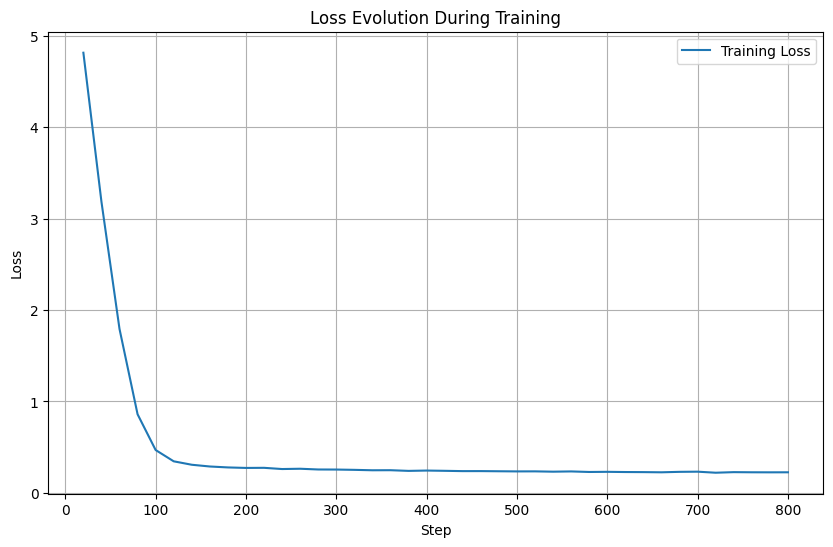

In [102]:
# epochs = 1

# for _ in range(epochs):
#     # trainer.evaluate()
trainer.train()
loss_tracker.plot_loss()

In [103]:
trainer.predict(test_dataset=test_dataset).metrics


{'test_loss': 0.6330957412719727,
 'test_runtime': 2.8816,
 'test_samples_per_second': 173.17,
 'test_steps_per_second': 1.388}

In [104]:
#guardar
model.save_pretrained("detox_model")

In [105]:
#cargar y probar
loaded_model = T5ForConditionalGeneration.from_pretrained("detox_model")
loaded_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [106]:
def detoxify_sentence(sentence, language):
  print(f"FRASE ORIGINAL: {sentence}")
  translated_sentence = translate(sentence, language, 'en')
  input_ids = tokenizer(translated_sentence, return_tensors="pt").input_ids.to(device)
  outputs = loaded_model.generate(input_ids)
  detoxified_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
  translated_detoxified_sentence = translate(detoxified_sentence, 'en', language)
  print(f"FRASE DETOXIFICADA: {translated_detoxified_sentence}")
  return translated_detoxified_sentence

In [112]:
sample = df_total[df_total["source_language"] == 'es'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language);

FRASE ORIGINAL: Ya empecé con la depresión de mierda
FRASE DETOXIFICADA: ya comencé con la depresión


In [114]:
sample = df_total[df_total["source_language"] == 'en'].sample(1)
toxic_sentence = sample['toxic_sentence'].iloc[0]
source_language = sample['source_language'].iloc[0]

detoxify_sentence(toxic_sentence, source_language);

FRASE ORIGINAL: FUCK Why hasn't anyone included this information yet?
FRASE DETOXIFICADA: Why hasn't anyone included this information yet?
